## Creating Relevant Input Variables

In [1]:
import ROOT

In [2]:
df = ROOT.RDataFrame("InputTreeSig", "inputSig.root")

In [3]:
df.GetColumnNames()

vector<string>{ "ADC_stdev", "ADC_tot", "GeV_tot", "Tf", "Ti", "Xf", "Xi", "Yf", "Yi", "Zf", "Zi", "docasqrx", "docasqrx_max", "docasqrx_min", "docasqry", "docasqry_max", "docasqry_min", "nxhits", "nyhits", "p_cross", "vrc_fit" }

First we remove NULL events

In [4]:
df = df.Filter("nxhits+nyhits > 0")

### 0) nhits_min

Here, we define the variable nhits_min = min{nxhits, nyhits}

In [5]:
ROOT.gInterpreter.Declare("""
int findMinhits(int nxhits, int nyhits){
        if (nxhits < nyhits)                  
            return nxhits;
        else 
            return nyhits;
}
""")

True

In [6]:
df = df.Define("nhits_min", "findMinhits(nxhits, nyhits)")

### 1) Track Length

First we have a look at TVector3 class in ROOT

In [7]:
v1 = ROOT.TVector3(1.0, 2.0, 3.0)
v2 = ROOT.TVector3(4.0, 5.0, 6.0)

(v1-v2).Mag()

5.196152422706632

Here, we define a function in C++ which takes in Input (Xi, Yi, Zi, Xf, Yf, Zf) and returns the distance between these points. This will give us the Track Length.

In [8]:
ROOT.gInterpreter.Declare('''
double FindDistance(double Xi, double Yi, double Zi, double Xf, double Yf, double Zf){
        TVector3 Pi(Xi, Yi, Zi);
        TVector3 Pf(Xf, Yf, Zf);
        return (Pf-Pi).Mag();                
}
''')


True

Now, we can use this function to define a new column in dataframe for Track Length

In [9]:
df = df.Define("Track_len", "FindDistance(Xi, Yi, Zi, Xf, Yf, Zf)")

### 2) Time of Flight

This can be defined as 
$$
Time\:of\:flight = T_f - T_i
$$

In [10]:
df = df.Define("Tof", "Tf - Ti")

### 3) Mean ADC

This is defined as,
$$
mean\:ADC = \frac{ADC_{tot}}{nxhits + nyhits}
$$

In [11]:
df = df.Define("ADC_mean", "ADC_tot/(nxhits + nyhits)")

### 4) EntryD

This variable is the ID of the surface through which particle entered. We do this by finding the closest surface to the initial position.
The ID assigned is as follows,\
1, 6 - XY surface planes (smallest ones)
2, 5 - XZ surface planes 
3, 4 - YZ surface planes of the detector

Thus, IDs with surfaces \
ID 1 -> zmin = 2.4 \
ID 2 -> xmin = -761.8 \
ID 3 -> ymin = -761.8 \
ID 4 -> ymax = 762.8 \
ID 5 -> xmax = 763.0 \
ID 6 -> zmax = 5960.0 \

In [12]:
# ROOT.gInterpreter.Declare("""
# #include<tuple>
# std::tuple<double,double,double,double,double,double>
# ReassignPos(double Xi, double Yi, double Zi, double Xf, double Yf, double Zf, double vrc_fit){
#     if(vrc_fit < 0){
#         return std::make_tuple(Xf, Yf, Zf, Xi, Yi, Zi);    
#     }
#     else{
#         return std::make_tuple(Xi, Yi, Zi, Xf, Yf, Zf);                      
#     }

# }

# """)

In [13]:
# df = df.Define("corrected_pos", "ReassignPos(Xi, Yi, Zi, Xf, Yf, Zf, vrc_fit)")

In [14]:
# df = df.Define("newXi", "std::get<0>(corrected_pos)")

In [15]:
# df = df.Define("newYi", "std::get<1>(corrected_pos)")
# df = df.Define("newZi", "std::get<2>(corrected_pos)")
# df = df.Define("newXf", "std::get<3>(corrected_pos)")
# df = df.Define("newYf", "std::get<4>(corrected_pos)")
# df = df.Define("newZf", "std::get<5>(corrected_pos)")

In [16]:
ROOT.gInterpreter.Declare("""
#include <array>

std::array<double, 6> ReassignPos(double Xi, double Yi, double Zi,
                                  double Xf, double Yf, double Zf,
                                  double vrc_fit) {
    if (vrc_fit < 0) {
        return {Xf, Yf, Zf, Xi, Yi, Zi};
    } else {
        return {Xi, Yi, Zi, Xf, Yf, Zf};
    }
}
""")

True

In [17]:
df = df.Define("reassigned", "ReassignPos(Xi, Yi, Zi, Xf, Yf, Zf, vrc_fit)")
df = df.Define("newXi", "reassigned[0]")\
       .Define("newYi", "reassigned[1]")\
       .Define("newZi", "reassigned[2]")\
       .Define("newXf", "reassigned[3]")\
       .Define("newYf", "reassigned[4]")\
       .Define("newZf", "reassigned[5]")

In [18]:
df.GetColumnNames()

vector<string>{ "ADC_mean", "ADC_stdev", "ADC_tot", "GeV_tot", "Tf", "Ti", "Tof", "Track_len", "Xf", "Xi", "Yf", "Yi", "Zf", "Zi", "docasqrx", "docasqrx_max", "docasqrx_min", "docasqry", "docasqry_max", "docasqry_min", "newXf", "newXi", "newYf", "newYi", "newZf", "newZi", "nhits_min", "nxhits", "nyhits", "p_cross", "reassigned", "vrc_fit" }

In [19]:
df.Display(["Xi", "newXi"]).Print()

+-----+-------------+-------------+
| Row | Xi          | newXi       | 
+-----+-------------+-------------+
| 0   | 760.140623  | 760.140623  | 
+-----+-------------+-------------+
| 1   | -750.029673 | -750.029673 | 
+-----+-------------+-------------+
| 2   | -429.915318 | 758.676254  | 
+-----+-------------+-------------+
| 3   | 761.336113  | 761.336113  | 
+-----+-------------+-------------+
| 4   | 458.565656  | 458.565656  | 
+-----+-------------+-------------+


Now, here we define a function in C++, which takes in position coordinates and returns the ID of closest surface as a an integer. This function could then be used for both entryD and exitD.

In [20]:
ROOT.gInterpreter.Declare('''
#include<cmath>
int ClosestSurface(double x, double y, double z){
    double xmin = -761.8;
    double xmax =  763.0;
    double ymin = -761.8;
    double ymax =  762.8;
    double zmin =  2.4;
    double zmax =  5960.0;

    double arr[6] = {std::abs(z - zmin), std::abs(x - xmin), std::abs(y - ymin), std::abs(y - ymax), std::abs(x - xmax), std::abs(z - zmax)};

    //We will return the index of minimum value
    int min_index = 0;
    double min_value = arr[0];

    for (int i = 1; i < 6; ++i){
        if (arr[i] < min_value){
            min_value = arr[i];
            min_index = i;                  
        }
    }

    return min_index+1;                                       
}
''')

True

Now we use this to define an entryD column,

In [21]:
df = df.Define("entryD", "ClosestSurface(newXi, newYi, newZi)")

In [22]:
df.Display("entryD").Print()

+-----+--------+
| Row | entryD | 
+-----+--------+
| 0   | 5      | 
+-----+--------+
| 1   | 2      | 
+-----+--------+
| 2   | 5      | 
+-----+--------+
| 3   | 5      | 
+-----+--------+
| 4   | 3      | 
+-----+--------+


### 5) ExitD

Using the same function we can also create the column for exit surface exitD, by inputing the final position variables

In [23]:
df = df.Define("exitD", "ClosestSurface(newXf, newYf, newZf)")

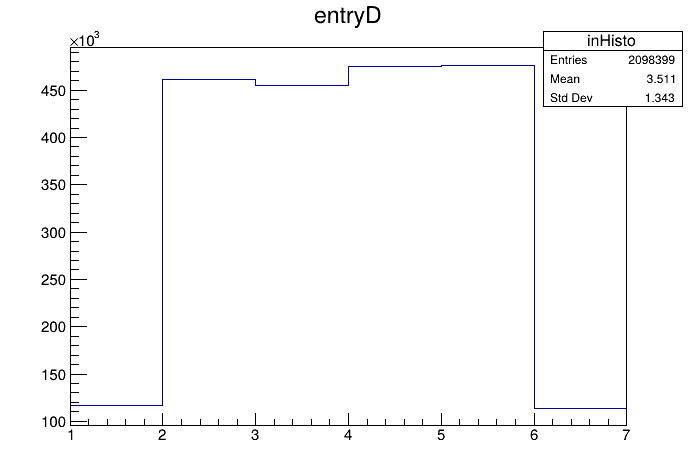

In [24]:
inHisto = df.Histo1D(("inHisto","entryD", 6, 1, 7),"entryD")

cin = ROOT.TCanvas()
inHisto.Draw()

cin.Draw()

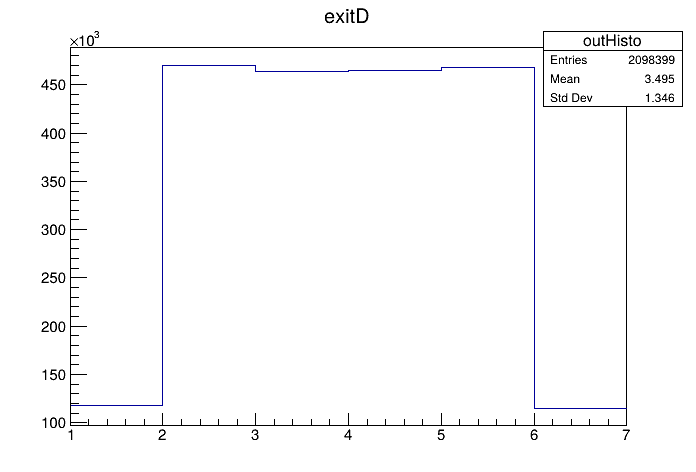

In [25]:
outHisto = df.Histo1D(("outHisto", "exitD", 6, 1, 7), "exitD")

cout = ROOT.TCanvas()
outHisto.Draw()
cout.Draw()

### 6) entry_dist

This variable here, finds the penetration distance of particle before 1st recorded hit, i.e., distance between entry surface and (newXi, newYi, newZi)

In [26]:
ROOT.gInterpreter.Declare('''
double PenDistance(double Xi, double Yi, double Zi, int entryD){
        double zmin =  2.4;          //ID 1
        double xmin = -761.8;        //ID 2
        double ymin = -761.8;        //ID 3
        double ymax =  762.8;        //ID 4
        double xmax =  763.0;        //ID 5
        double zmax =  5960.0;       //ID 6
                          
        if (entryD == 1)
                return std::abs(std::abs(Zi) - std::abs(zmin));
        else if (entryD == 2)
                return std::abs(std::abs(Xi) - std::abs(xmin));
        else if (entryD == 3)
                return std::abs(std::abs(Yi) - std::abs(ymin));                 
        else if (entryD == 4)
                return std::abs(std::abs(Yi) - std::abs(ymax));
        else if (entryD == 5)
                return std::abs(std::abs(Xi) - std::abs(xmax));
        else 
                return std::abs(std::abs(Zi) - std::abs(zmax));
}
''')

True

So, now we can find the initial penetration distance entry_dist

In [27]:
df = df.Define("entry_dist", "PenDistance(newXi, newYi, newZi, entryD)")

In [28]:
df.GetColumnNames()

vector<string>{ "ADC_mean", "ADC_stdev", "ADC_tot", "GeV_tot", "Tf", "Ti", "Tof", "Track_len", "Xf", "Xi", "Yf", "Yi", "Zf", "Zi", "docasqrx", "docasqrx_max", "docasqrx_min", "docasqry", "docasqry_max", "docasqry_min", "entryD", "entry_dist", "exitD", "newXf", "newXi", "newYf", "newYi", "newZf", "newZi", "nhits_min", "nxhits", "nyhits", "p_cross", "reassigned", "vrc_fit" }

In [29]:
df.Display("entry_dist").Print()

+-----+------------+
| Row | entry_dist | 
+-----+------------+
| 0   | 2.859377   | 
+-----+------------+
| 1   | 11.770327  | 
+-----+------------+
| 2   | 4.323746   | 
+-----+------------+
| 3   | 1.663887   | 
+-----+------------+
| 4   | 7.806055   | 
+-----+------------+


### 7)exit_dist

This variable is the distance between final recorded position of the particle and the exit surface(closest surface)

In [30]:
df = df.Define("exit_dist", "PenDistance(newXf, newYf, newZf, exitD)")

In [31]:
df.Display(["entry_dist", "exit_dist"]).Print()

+-----+------------+-----------+
| Row | entry_dist | exit_dist | 
+-----+------------+-----------+
| 0   | 2.859377   | 1.372492  | 
+-----+------------+-----------+
| 1   | 11.770327  | 7.576132  | 
+-----+------------+-----------+
| 2   | 4.323746   | 12.872739 | 
+-----+------------+-----------+
| 3   | 1.663887   | 2.757146  | 
+-----+------------+-----------+
| 4   | 7.806055   | 4.032070  | 
+-----+------------+-----------+


### 8) $\beta$

This can be calculated (in units of cm/ns),
$$
beta = \frac{vrc_{fit}}{30}
$$

In [32]:
df = df.Define("beta", "std::abs(vrc_fit)/30")

In [33]:
df.Display(["beta"]).Print()

+-----+----------+
| Row | beta     | 
+-----+----------+
| 0   | 0.019764 | 
+-----+----------+
| 1   | 0.018306 | 
+-----+----------+
| 2   | 0.020271 | 
+-----+----------+
| 3   | 0.019781 | 
+-----+----------+
| 4   | 0.019793 | 
+-----+----------+


### 9) $\log(\frac{dE}{dx})$

This can be calculated as follows,
$$
\log(\frac{dE}{dx}) = \frac{GeV_{tot}}{Track\:length}
$$

In [34]:
df = df.Define("dEdx", "GeV_tot/Track_len")

In [35]:
df = df.Filter("dEdx > 0")

In [36]:
df = df.Define("logdEdx", "std::log(dEdx)")

In [37]:
df.Display("logdEdx").Print()

+-----+-----------+
| Row | logdEdx   | 
+-----+-----------+
| 0   | -3.560363 | 
+-----+-----------+
| 1   | -3.813556 | 
+-----+-----------+
| 2   | -3.627090 | 
+-----+-----------+
| 3   | -3.626783 | 
+-----+-----------+
| 4   | -3.876508 | 
+-----+-----------+


In [38]:
df.GetColumnNames()

vector<string>{ "ADC_mean", "ADC_stdev", "ADC_tot", "GeV_tot", "Tf", "Ti", "Tof", "Track_len", "Xf", "Xi", "Yf", "Yi", "Zf", "Zi", "beta", "dEdx", "docasqrx", "docasqrx_max", "docasqrx_min", "docasqry", "docasqry_max", "docasqry_min", "entryD", "entry_dist", "exitD", "exit_dist", "logdEdx", "newXf", "newXi", "newYf", "newYi", "newZf", "newZi", "nhits_min", "nxhits", "nyhits", "p_cross", "reassigned", "vrc_fit" }

### 10) docasqrx_mean and docasqry_mean

In [39]:
df = df.Define("docasqrx_mean", "docasqrx/nxhits")
df = df.Define("docasqry_mean", "docasqry/nyhits")

In [40]:
df.GetColumnNames()

vector<string>{ "ADC_mean", "ADC_stdev", "ADC_tot", "GeV_tot", "Tf", "Ti", "Tof", "Track_len", "Xf", "Xi", "Yf", "Yi", "Zf", "Zi", "beta", "dEdx", "docasqrx", "docasqrx_max", "docasqrx_mean", "docasqrx_min", "docasqry", "docasqry_max", "docasqry_mean", "docasqry_min", "entryD", "entry_dist", "exitD", "exit_dist", "logdEdx", "newXf", "newXi", "newYf", "newYi", "newZf", "newZi", "nhits_min", "nxhits", "nyhits", "p_cross", "reassigned", "vrc_fit" }

In [41]:
df.Snapshot("OutputTreeSig", "outputSig.root")

<cppyy.gbl.ROOT.RDF.RResultPtr<ROOT::RDF::RInterface<ROOT::Detail::RDF::RLoopManager,void> > object at 0x58dea5cedb30>